In [252]:
%matplotlib inline
import matplotlib as lib
import pandas as pd
from bs4 import BeautifulSoup
import requests
import json
from altair import *
from ggplot import *
import numpy as np
import seaborn as sbn

In [208]:
df=pd.read_excel('chapter-12-relay-foods.xlsx',sheetname='Purchase Data - Full Study')

In [209]:
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


In [210]:
def getOrderPeriod(row):
    return row['OrderDate'].strftime('%Y-%m')
df['OrderPeriod']=df.apply(getOrderPeriod,axis=1)
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,2009-01
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2009-01
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04,2009-02
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09,2009-02
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09,2009-02


In [211]:
x=df.groupby(['UserId']).first()
x=x.reset_index()
x['CohortGroup']=x['OrderPeriod']
y=pd.merge(df,x[['UserId','CohortGroup']],right_on='UserId',left_on='UserId')
pf=y
pf.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,2009-01,2009-01
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2009-01,2009-01
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04,2009-02,2009-01
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09,2009-02,2009-01
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09,2009-02,2009-01


In [212]:
x=pf.groupby(['UserId','CohortGroup','OrderPeriod']).sum()['TotalCharges']
x=x.reset_index()
chg=x.groupby(['CohortGroup','OrderPeriod']).sum()['TotalCharges']
chg=chg.reset_index()
chg.head()

,CohortGroup,OrderPeriod,TotalCharges
0,2009-01,2009-01,1850.255
1,2009-01,2009-02,1351.065
2,2009-01,2009-03,1357.360
3,2009-01,2009-04,1604.500
4,2009-01,2009-05,1575.625


In [213]:
#potentially do total number of User and total number of Orders
chg2=pf.groupby(['CohortGroup','OrderPeriod']).agg({
        'UserId':pd.Series.nunique,
        'OrderId':pd.Series.nunique,
        'TotalCharges':np.sum
    })
chg2.rename(columns={'UserId':'TotalUsers','OrderId':'TotalOrders'},inplace=True)
chg2.head()

TotalOrders  TotalCharges  TotalUsers
CohortGroup OrderPeriod                                       
2009-01     2009-01               30      1850.255          22
            2009-02               25      1351.065           8
            2009-03               26      1357.360          10
            2009-04               28      1604.500           9
            2009-05               26      1575.625          10

## Now label the 'cohortPeriod' for each cohort group

In [214]:
#ef['d']=list(range(len('c')))
def cp(df):
    df['CohortPeriod']=list(range(1,len(df)+1))
    return df
chg2=chg2.groupby(level=0).apply(cp)
chg2.head()

TotalOrders  TotalCharges  TotalUsers  CohortPeriod
CohortGroup OrderPeriod                                                     
2009-01     2009-01               30      1850.255          22             1
            2009-02               25      1351.065           8             2
            2009-03               26      1357.360          10             3
            2009-04               28      1604.500           9             4
            2009-05               26      1575.625          10             5

In [215]:
tem=chg2.reset_index()
tem.head()
#reset index for the pivot table

,CohortGroup,OrderPeriod,TotalOrders,TotalCharges,TotalUsers,CohortPeriod
0,2009-01,2009-01,30,1850.255,22,1
1,2009-01,2009-02,25,1351.065,8,2
2,2009-01,2009-03,26,1357.360,10,3
3,2009-01,2009-04,28,1604.500,9,4
4,2009-01,2009-05,26,1575.625,10,5


In [219]:
tem.pivot_table(index='CohortPeriod',values='TotalUsers',columns='CohortGroup')

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,,,,,
1,22.0,15.0,13.0,39.0,50.0,32.0,50.0,31.0,37.0,54.0,130.0,65.0,95.0,100.0,24.0
2,8.0,3.0,4.0,13.0,13.0,15.0,23.0,11.0,15.0,17.0,32.0,17.0,50.0,19.0,NaN
3,10.0,5.0,5.0,10.0,12.0,9.0,13.0,9.0,14.0,12.0,26.0,18.0,26.0,NaN,NaN
4,9.0,1.0,4.0,13.0,5.0,6.0,10.0,7.0,8.0,13.0,29.0,7.0,NaN,NaN,NaN
5,10.0,4.0,1.0,6.0,4.0,7.0,11.0,6.0,13.0,13.0,13.0,NaN,NaN,NaN,NaN
6,8.0,4.0,2.0,7.0,6.0,5.0,10.0,8.0,9.0,7.0,NaN,NaN,NaN,NaN,NaN
7,8.0,4.0,2.0,4.0,3.0,3.0,11.0,4.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
8,7.0,5.0,3.0,6.0,5.0,3.0,7.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,7.0,5.0,2.0,2.0,5.0,10.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [233]:
z=tem.groupby('CohortGroup').first()
z.reset_index()
z=z.reset_index()
temp2=pd.merge(tem,z[['CohortGroup','TotalUsers']],right_on='CohortGroup',left_on='CohortGroup')
temp2['retention']=temp2['TotalUsers_x']/temp2['TotalUsers_y']
temp2.head()

,CohortGroup,OrderPeriod,TotalOrders,TotalCharges,TotalUsers_x,CohortPeriod,TotalUsers_y,retention
0,2009-01,2009-01,30,1850.255,22,1,22,1.000000
1,2009-01,2009-02,25,1351.065,8,2,22,0.363636
2,2009-01,2009-03,26,1357.360,10,3,22,0.454545
3,2009-01,2009-04,28,1604.500,9,4,22,0.409091
4,2009-01,2009-05,26,1575.625,10,5,22,0.454545


In [249]:
retention=temp2.pivot_table(index='CohortPeriod',values='retention',columns='CohortGroup')
retention.head()

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.00,1.00000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.0
2,0.363636,0.200000,0.307692,0.333333,0.26,0.46875,0.46,0.354839,0.405405,0.314815,0.246154,0.261538,0.526316,0.19,NaN
3,0.454545,0.333333,0.384615,0.256410,0.24,0.28125,0.26,0.290323,0.378378,0.222222,0.200000,0.276923,0.273684,NaN,NaN
4,0.409091,0.066667,0.307692,0.333333,0.10,0.18750,0.20,0.225806,0.216216,0.240741,0.223077,0.107692,NaN,NaN,NaN
5,0.454545,0.266667,0.076923,0.153846,0.08,0.21875,0.22,0.193548,0.351351,0.240741,0.100000,NaN,NaN,NaN,NaN


## Graph user retention by cohort group
1. Make a line graph
2. Make a heat map

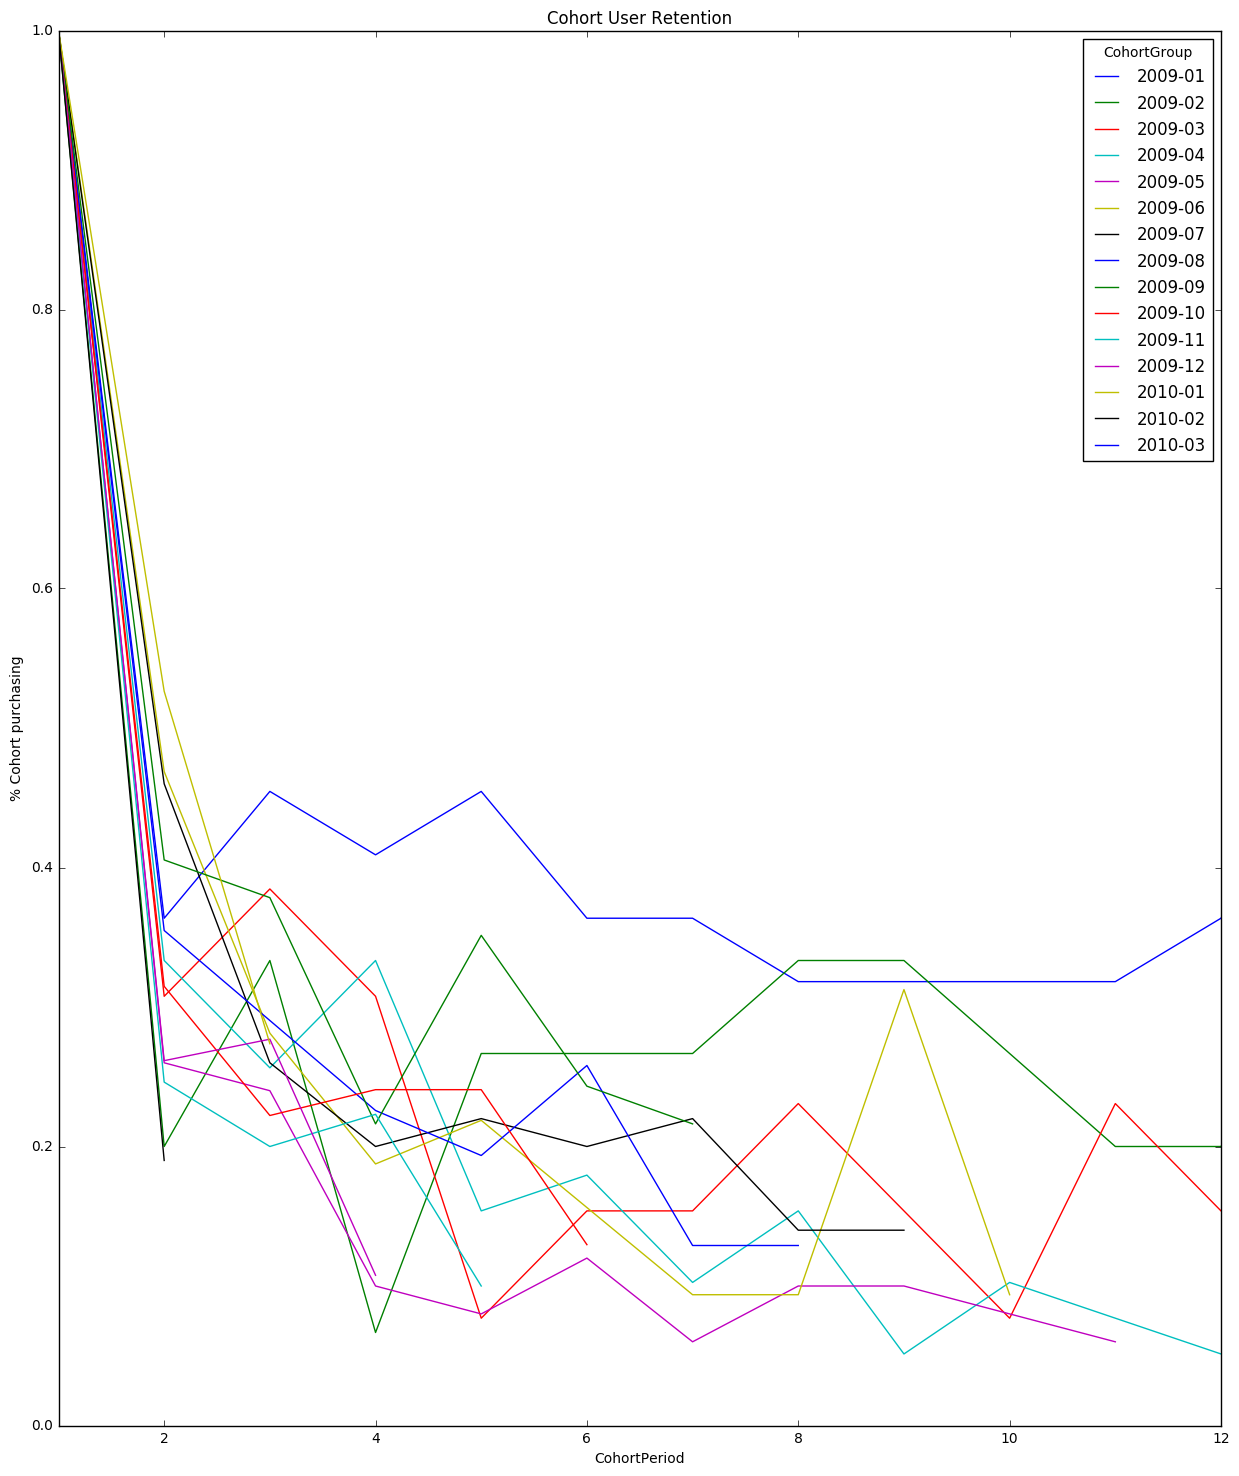

In [246]:
ax=retention.plot(figsize=(15,18))
ax.set_title('Cohort User Retention')
ax.set_xlim(1,12)
ax.set_ylabel('% Cohort purchasing')

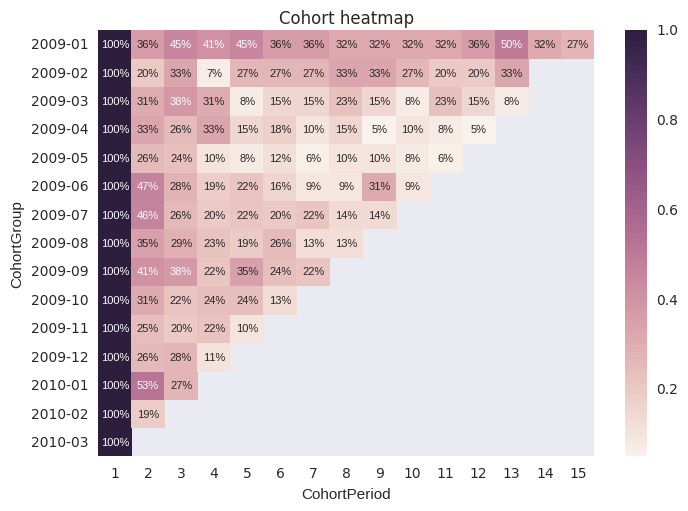

In [265]:
ax=sbn.heatmap(retention.T,mask=retention.T.isnull(),annot=True,fmt='.0%',annot_kws={"size":8})
ax
ax.set_title('Cohort heatmap')

In [238]:
def heatmap(data, row, column, color, cellsize=(30, 15)):
    """Create an Altair Heat-Map

    Parameters
    ----------
    row, column, color : str
        Altair trait shorthands
    cellsize : tuple
        specify (width, height) of cells in pixels
    """
    return Chart(data).mark_text(
               applyColorToBackground=True,
           ).encode(
               row=row,
               column=column,
               text=Text(value=' '),
               color=color
           ).configure_scale(
               textBandWidth=cellsize[0],
               bandSize=cellsize[1]
           )


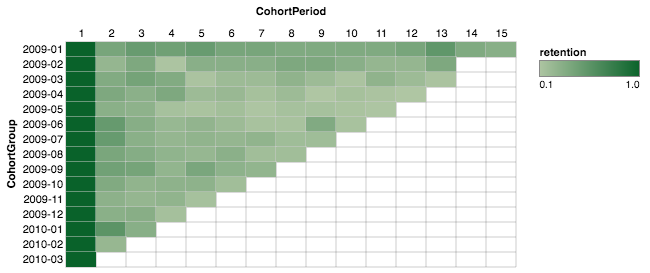

In [251]:
heatmap(temp2, row='CohortGroup', column='CohortPeriod', color='retention')